In [ ]:
# # # cheking the number of cored this system has.
# !cat /proc/cpuinfo | grep "cpu cores" | uniq

# # GPU info
# !nvidia-smi

# # Amount of system RAM available to be used.
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / (1024 * 1024 * 1024)   
# print('Your runtime has {:.1f} gigabyte of availabe\n'.format(ram_gb))

# #finding the recursion limit to avoid Augmentation recursion error 
# import sys
# print(sys.getrecursionlimit())

# #installing fastai
# !pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
#importing libraries and initializing fastai 
import pandas as pd 
import numpy as np 
import time

#Mounting google drive for saving the models after training 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#loading the data 
#There are NaN values in the consumer_complaint_narrative column
train_raw = pd.read_csv('/content/drive/MyDrive/consumer_complaints.csv')
train_raw.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [ ]:
#Training data shape
train_raw.shape

(555957, 18)

In [ ]:
#Preprocessing the data 
#Extracting only those data whose consumer_complaint_narrative column is not null
#columns = 18
train_raw = train_raw[train_raw.consumer_complaint_narrative.notnull()]
train_raw.shape

(66806, 18)

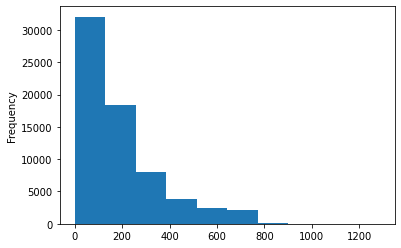

In [ ]:
#It splits the string into , separated values 
train_raw.consumer_complaint_narrative.apply(lambda x:len(x.split())).plot(kind='hist')

In [ ]:
train_raw['len_txt'] =train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split()))

In [ ]:
train_raw.describe()

,complaint_id,len_txt
count,6.680600e+04,66806.000000
mean,1.571665e+06,190.644014
std,1.545692e+05,166.830597
min,1.290181e+06,1.000000
25%,1.443264e+06,71.000000
50%,1.569485e+06,136.000000
75%,1.702750e+06,254.000000
max,1.888608e+06,1284.000000


In [ ]:
train_raw.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zipcode', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed?', 'complaint_id', 'len_txt'],
      dtype='object')

In [ ]:
train_raw.shape

(66806, 19)

In [ ]:
#Select only the rows with more than 250 words 
train_raw = train_raw[train_raw.len_txt >249]
train_raw.shape

(17142, 19)

In [ ]:
train_raw.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id,len_txt
190155,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524,666
190208,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,NaN,XXXX was submitted XX/XX/XXXX. At the time I s...,NaN,Rushmore Loan Management Services LLC,CA,956XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1292137,259
190251,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I spoke to XXXX of green tree representatives ...,NaN,Ditech Financial LLC,CA,948XX,NaN,Consent provided,Web,03/19/2015,Closed with non-monetary relief,Yes,No,1290534,301
190263,03/19/2015,Credit card,NaN,Other,NaN,i opened XXXX Bank of America credit cards 15-...,Company chooses not to provide a public response,Bank of America,OR,971XX,NaN,Consent provided,Web,03/19/2015,Closed with monetary relief,Yes,Yes,1292209,780
190264,03/19/2015,Consumer Loan,Vehicle loan,Taking out the loan or lease,NaN,I applied for a loan with XXXX XXXX and had pu...,NaN,Hyundai Capital America,MS,392XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1292159,558


In [ ]:
#selecting only the consumer_complaint_narrative and product columns
train_raw=train_raw[['consumer_complaint_narrative','product']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
train_raw['product'].unique()

array(['Mortgage', 'Credit card', 'Consumer Loan', 'Debt collection',
       'Credit reporting', 'Student loan', 'Bank account or service',
       'Money transfers', 'Payday loan', 'Prepaid card',
       'Other financial service'], dtype=object)

In [ ]:
#group similar products  dataframe.at = accessing a value using row column pair 
train_raw.at[train_raw['product']=='Credit reporting','product']= 'Credit reporting, credit repair services, or other personal consumer reports'
train_raw.at[train_raw['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Prepaid card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Payday loan', 'product'] = 'Payday loan, title loan, or personal loan'
train_raw.at[train_raw['product'] == 'Virtual currency', 'product'] = 'Money transfer, virtual currency, or money service'
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
train_raw['product'].unique()

array(['Mortgage', 'Credit card or prepaid card', 'Consumer Loan',
       'Debt collection',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Student loan', 'Bank account or service', 'Money transfers',
       'Payday loan, title loan, or personal loan',
       'Other financial service'], dtype=object)

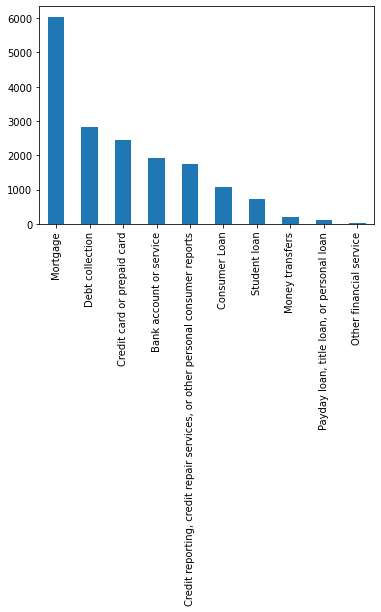

In [ ]:
train_raw['product'].value_counts().sort_values(ascending=False).plot(kind='bar')
#unbalanced dataset 

In [ ]:
#Renaming the columns 
train_raw=train_raw.rename(columns = {'consumer_complaint_narrative':'text', 'product':'label'})
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
#changing the categorical value column to integers

from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,6
1,XXXX was submitted XX/XX/XXXX. At the time I s...,6
2,I spoke to XXXX of green tree representatives ...,6
3,i opened XXXX Bank of America credit cards 15-...,2
4,I applied for a loan with XXXX XXXX and had pu...,1


In [ ]:
len(np.unique(train_raw['label']))

10

In [ ]:
#creating the copy of the dataframe
#dataframe.copy(deep=True)  ==> This will create a copy and any changes to the copy will not be reflected in the original df
train = train_raw.copy()

In [ ]:
#reindexing to create randomness 
train = train.reindex(np.random.permutation(train.index))
train.head()

,text,label
8539,Two years ago I made a Trust Deed Investment t...,6
3721,I was advised by XXXX employees ( XXXX males )...,1
12550,I am receiving threatening phone calls from a ...,8
16904,We have XXXX auto loans with Ally fin. XXXX is...,1
1575,"For the past year, or more, scince changing ph...",4


In [ ]:
#remove the non-alphanumeric characters from the text 
import re 
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)     #() -- to match the sequence inside it , \-- to escape the special characters , 
                                     #\W -- get all the nonalphanumeric characters, + --all the instances 

  return text

In [ ]:
train['text']  = train.text.apply(clean_txt)
train.head()

,text,label
8539,Two years ago I made a Trust Deed Investment t...,6
3721,I was advised by XXXX employees XXXX males tha...,1
12550,I am receiving threatening phone calls from a ...,8
16904,We have XXXX auto loans with Ally fin XXXX is ...,1
1575,For the past year or more scince changing phon...,4


In [ ]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label
0,Two years ago I made a Trust Deed Investment t...,6
1,I was advised by XXXX employees XXXX males tha...,1


In [ ]:
train.shape

(17142, 2)

In [ ]:
# val.reset_index(drop=True, inplace=True)
# val.head(2)

In [ ]:
# val.shape, train.shape

In [ ]:
!pip install tensorflow==2.5.0

In [ ]:
#Installing the BERT module
!pip install bert-tensorflow
#!pip install bert-for-tf2

import bert
from bert import optimization

!pip install -q tf-models-official==2.4.0

import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [ ]:
print(tf.__version__)

2.5.0



# Setting The Output Directory for BERT



In [ ]:
#Setting the output directory for BERT 
# Set the output directory for saving model file
OUTPUT_DIR = '/content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.io.gfile.DeleteRecursively(OUTPUT_DIR)#deletes everything under the directory recursively
  except:
    pass

tf.io.gfile.makedirs(OUTPUT_DIR) #Creates a directory and all parent/intermediate directories.
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC *****


In [ ]:
print("Training Set Shape :", train.shape)
#print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (17142, 2)


In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Splitting the Data into smaller chunks

In [ ]:
#Splitting the data into smaller chunks 
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200] #overlapping 50 words in every chunks 
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
def get_split_count(text1):
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  return n

In [ ]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

,text,label,text_split
0,Two years ago I made a Trust Deed Investment t...,6,[Two years ago I made a Trust Deed Investment ...
1,I was advised by XXXX employees XXXX males tha...,1,[I was advised by XXXX employees XXXX males th...
2,I am receiving threatening phone calls from a ...,8,[I am receiving threatening phone calls from a...
3,We have XXXX auto loans with Ally fin XXXX is ...,1,[We have XXXX auto loans with Ally fin XXXX is...
4,For the past year or more scince changing phon...,4,[For the past year or more scince changing pho...


In [ ]:
train['text_split_count'] = train[DATA_COLUMN].apply(get_split_count)
train.head()

,text,label,text_split,text_split_count
0,Two years ago I made a Trust Deed Investment t...,6,[Two years ago I made a Trust Deed Investment ...,3
1,I was advised by XXXX employees XXXX males tha...,1,[I was advised by XXXX employees XXXX males th...,1
2,I am receiving threatening phone calls from a ...,8,[I am receiving threatening phone calls from a...,2
3,We have XXXX auto loans with Ally fin XXXX is ...,1,[We have XXXX auto loans with Ally fin XXXX is...,2
4,For the past year or more scince changing phon...,4,[For the past year or more scince changing pho...,1


In [ ]:
train.shape

(17142, 4)

In [ ]:
count_1 =0
count_2 =0
count_3 =0
count_4 =0
count_5 =0
for i in train['text_split_count']:
  if i==5:
    count_5+=1
  if i==1:
    count_1+=1
  if i==2:
    count_2+=1
  if i==3:
    count_3+=1
  if i==4:
    count_4+=1

In [ ]:
print('count_1 ', count_1)
print('count_2 ', count_2)
print('count_3 ', count_3)
print('count_4 ', count_4)
print('count_5 ', count_5)

count_1  4045
count_2  6873
count_3  3264
count_4  2758
count_5  202


In [ ]:
#creating the test set
test_set = train[(train['text_split_count'] == 5)]

In [ ]:
test_set

,text,label,text_split,text_split_count
135,I bought home in XX XX XXXX taxes were escrowe...,6,[I bought home in XX XX XXXX taxes were escrow...,5
155,The customer service for M T bank is not forth...,6,[The customer service for M T bank is not fort...,5
382,I lost my home of 25 years to a preditory lend...,6,[I lost my home of 25 years to a preditory len...,5
475,My mortgage was transferred to freedom mortgag...,6,[My mortgage was transferred to freedom mortga...,5
641,This has been going on since XXXX XXXX 2015 Wa...,2,[This has been going on since XXXX XXXX 2015 W...,5
...,...,...,...,...
16658,Cash Central ran their debit through my Bank a...,8,[Cash Central ran their debit through my Bank ...,5
16783,I received a call from a debt collection agenc...,4,[I received a call from a debt collection agen...,5
16794,I bought my house in XXXX XXXX From that time ...,6,[I bought my house in XXXX XXXX From that time...,5
16836,On XXXX XXXX my wife sent a mortgage payment b...,6,[On XXXX XXXX my wife sent a mortgage payment ...,5


In [ ]:
train.shape , test_set.shape

((17142, 4), (202, 4))

In [ ]:
train = train[(train['text_split_count'].isin([1,2,3,4]))]

In [ ]:
train.shape

(16940, 4)

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)
train.head()

,text,label,text_split,text_split_count
12321,I opened a loan with Santander XX XX XXXX and ...,1,[I opened a loan with Santander XX XX XXXX and...,2
12026,I went through a bad divorce and my former spo...,3,[I went through a bad divorce and my former sp...,1
1151,Hello I disputed an innacurate collection acco...,3,[Hello I disputed an innacurate collection acc...,1
1274,This complaint is against Bank of America N A ...,4,[This complaint is against Bank of America N A...,2
10121,My story is similar to some I ve read Around o...,4,[My story is similar to some I ve read Around ...,3


In [ ]:
train.shape, val.shape, test_set.shape

((13552, 4), (3388, 4), (202, 4))

In [ ]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:  #it is going to create list of training chunks with label and index mapping 
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(30871, 30871, 30871)

In [ ]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(7744, 7744, 7744)

In [ ]:
test_l = []
test_label_l = []
test_index_l = []
for idx,row in test_set.iterrows():
  for l in row['text_split']:
    test_l.append(l)
    test_label_l.append(row['label'])
    test_index_l.append(idx)
len(test_l), len(test_label_l), len(test_index_l)

(1010, 1010, 1010)

In [ ]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,I opened a loan with Santander XX XX XXXX and ...,1
1,is by Santander as well I have disputed the re...,1
2,I went through a bad divorce and my former spo...,3
3,Hello I disputed an innacurate collection acco...,3
4,This complaint is against Bank of America N A ...,4


In [ ]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,I was cheated by BB T and the XXXX could not h...,0
1,7 00 on a dormant account I questioned the cha...,0
2,by writing I did not get any response So pleas...,0
3,During the time my daughter was in college I o...,2
4,calling me about a late payment and I told the...,2


In [ ]:
test_df = pd.DataFrame({DATA_COLUMN:test_l, LABEL_COLUMN:test_label_l})
test_df.head()

,text,label
0,I bought home in XX XX XXXX taxes were escrowe...,6
1,with XXXX XXXX a t Selene this lasted for 9mon...,6
2,they transferred over the escrow to XXXX After...,6
3,let s do the math They credited me for 2600 00...,6
4,XX XXXX XX XX XXXX and XX XX XXXX Then in XX X...,6


In [ ]:
print('train_df shape : ',train_df.shape)
print('val_df shape : ',val_df.shape)
print('test_df shape : ',test_df.shape)

train_df shape :  (30871, 2)
val_df shape :  (7744, 2)
test_df shape :  (1010, 2)


# BERT: Data Preprocessing

In [ ]:
class PaddingInputExample(object):
      pass

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [ ]:
train_InputExamples_1 = train_df.apply(lambda x: InputExample(guid=None,
                                                                  text_a = x[DATA_COLUMN], 
                                                                  text_b = None, 
                                                                  label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
train_InputExamples_1

0        <__main__.InputExample object at 0x7fe5543db690>
1        <__main__.InputExample object at 0x7fe5543d5c50>
2        <__main__.InputExample object at 0x7fe554abbc90>
3        <__main__.InputExample object at 0x7fe554abb0d0>
4        <__main__.InputExample object at 0x7fe55437f790>
                               ...                       
30866    <__main__.InputExample object at 0x7fe553cb8b90>
30867    <__main__.InputExample object at 0x7fe553cb8bd0>
30868    <__main__.InputExample object at 0x7fe553cb8c10>
30869    <__main__.InputExample object at 0x7fe553cb8c50>
30870    <__main__.InputExample object at 0x7fe553cb8c90>
Length: 30871, dtype: object

In [ ]:
print("Row 0 - guid of training set : ", train_InputExamples_1.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples_1.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples_1.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples_1.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  I opened a loan with Santander XX XX XXXX and was financed XXXX at 16 99 interest rate on my loan for 72 months which should equate to 26000 00 in finance charges equaling a monthly payment of 370 00 and I have been paying 370 00 I made my payments accordingly over the next 4 years I tried refinancing my loan in XX XX XXXX as well a trade in my vehicle around the same time Come to find out I was severely upside down and no one would finance me a new loan with my vehicle as a trade or refinance because my debt owed was to high At that time I allowed my vehicle to repossessed due to the amount owed I feel I am a victim of a predatory lending from Santander and now my credit history is be slandered and portrayed worse than it actually is by Santander as well I have disputed the reporting of my account as per my rights of FCRA due incorrect payment history reporting first date of delinquency on my account re

In [ ]:
val_InputExamples_1 = val_df.apply(lambda x: InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
test_InputExamples_1 = test_df.apply(lambda x: InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

# BERT: Loading the pre-trained model

In [ ]:
import official.nlp.bert.tokenization as tokenization

In [ ]:
# ##We are creatung the tokens to gorm the vocabulary which inturn is ued to represent the words
# #BERT: Loading the pre-trained model
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.compat.v1.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
len(tokenizer.vocab.keys())

30522

In [ ]:
#Defining Input features 
class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id,
               is_real_example=True):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id
    self.is_real_example = is_real_example

In [ ]:
def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

In [ ]:
def convert_examples_to_features(tokenizer, examples, max_seq_length=200):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels,features = [], [], [], [],[]
    for example in tqdm.tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )

        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)

        feature = InputFeatures(input_ids=input_id,
        input_mask=input_mask,
        segment_ids=segment_id,
        label_id=label,
        is_real_example=True)

        features.append(feature)
    # return(
    #     np.array(input_ids),
    #     np.array(input_masks),
    #     np.array(segment_ids),
    #     np.array(labels).reshape(-1, 1),
    # )
    return features

In [ ]:
import tqdm
MAX_SEQ_LENGTH = 200

In [ ]:
# Convert our train and validation features to InputFeatures that BERT understands.

train_features = convert_examples_to_features(tokenizer, train_InputExamples_1, MAX_SEQ_LENGTH)

val_features = convert_examples_to_features(tokenizer, val_InputExamples_1, MAX_SEQ_LENGTH)

test_features = convert_examples_to_features(tokenizer, test_InputExamples_1, MAX_SEQ_LENGTH)

Converting examples to features: 100%|██████████| 1010/1010 [00:03<00:00, 284.84it/s]


In [ ]:
print("Sentence : ", train_InputExamples_1.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples_1.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  I opened a loan with Santander XX XX XXXX and was financed XXXX at 16 99 interest rate on my loan for 72 months which should equate to 26000 00 in finance charges equaling a monthly payment of 370 00 and I have been paying 370 00 I made my payments accordingly over the next 4 years I tried refinancing my loan in XX XX XXXX as well a trade in my vehicle around the same time Come to find out I was severely upside down and no one would finance me a new loan with my vehicle as a trade or refinance because my debt owed was to high At that time I allowed my vehicle to repossessed due to the amount owed I feel I am a victim of a predatory lending from Santander and now my credit history is be slandered and portrayed worse than it actually is by Santander as well I have disputed the reporting of my account as per my rights of FCRA due incorrect payment history reporting first date of delinquency on my account repeatedly reported inaccurately a charged off account reporting open 9 m

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1]

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [ ]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# # Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
num_train_steps, len(label_list)

(1929, 10)

In [ ]:
# #Initializing the model and the estimator   <USE THIS BLOCK IF YOU ARE TRAINING FOR THE FIRST TIME>
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': '/content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn

In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
import datetime

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# #Just for reference -->DO NOT RUN IT
# #BERT: Fine Tuning Training & Evaluating
print(f'Beginning Training!')
#current_time = datetime.time()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
#print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 2.1322918, step = 0


INFO:tensorflow:loss = 2.1322918, step = 0


INFO:tensorflow:global_step/sec: 1.92664


INFO:tensorflow:global_step/sec: 1.92664


INFO:tensorflow:loss = 1.5549669, step = 100 (51.906 sec)


INFO:tensorflow:loss = 1.5549669, step = 100 (51.906 sec)


INFO:tensorflow:global_step/sec: 2.47459


INFO:tensorflow:global_step/sec: 2.47459


INFO:tensorflow:loss = 0.7525867, step = 200 (40.411 sec)


INFO:tensorflow:loss = 0.7525867, step = 200 (40.411 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:global_step/sec: 2.10487


INFO:tensorflow:global_step/sec: 2.10487


INFO:tensorflow:loss = 0.24837455, step = 300 (47.514 sec)


INFO:tensorflow:loss = 0.24837455, step = 300 (47.514 sec)


INFO:tensorflow:global_step/sec: 2.4743


INFO:tensorflow:global_step/sec: 2.4743


INFO:tensorflow:loss = 0.49126095, step = 400 (40.410 sec)


INFO:tensorflow:loss = 0.49126095, step = 400 (40.410 sec)


INFO:tensorflow:global_step/sec: 2.47588


INFO:tensorflow:global_step/sec: 2.47588


INFO:tensorflow:loss = 0.42685127, step = 500 (40.390 sec)


INFO:tensorflow:loss = 0.42685127, step = 500 (40.390 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:global_step/sec: 2.10351


INFO:tensorflow:global_step/sec: 2.10351


INFO:tensorflow:loss = 0.85342455, step = 600 (47.539 sec)


INFO:tensorflow:loss = 0.85342455, step = 600 (47.539 sec)


INFO:tensorflow:global_step/sec: 2.47504


INFO:tensorflow:global_step/sec: 2.47504


INFO:tensorflow:loss = 0.7204707, step = 700 (40.404 sec)


INFO:tensorflow:loss = 0.7204707, step = 700 (40.404 sec)


INFO:tensorflow:global_step/sec: 2.4761


INFO:tensorflow:global_step/sec: 2.4761


INFO:tensorflow:loss = 0.37335747, step = 800 (40.385 sec)


INFO:tensorflow:loss = 0.37335747, step = 800 (40.385 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...


INFO:tensorflow:Saving checkpoints for 900 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 900 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...


INFO:tensorflow:global_step/sec: 2.13399


INFO:tensorflow:global_step/sec: 2.13399


INFO:tensorflow:loss = 0.1747292, step = 900 (46.860 sec)


INFO:tensorflow:loss = 0.1747292, step = 900 (46.860 sec)


INFO:tensorflow:global_step/sec: 2.47446


INFO:tensorflow:global_step/sec: 2.47446


INFO:tensorflow:loss = 0.42678523, step = 1000 (40.413 sec)


INFO:tensorflow:loss = 0.42678523, step = 1000 (40.413 sec)


INFO:tensorflow:global_step/sec: 2.47534


INFO:tensorflow:global_step/sec: 2.47534


INFO:tensorflow:loss = 0.48908854, step = 1100 (40.401 sec)


INFO:tensorflow:loss = 0.48908854, step = 1100 (40.401 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1200...


INFO:tensorflow:Saving checkpoints for 1200 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1200 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1200...


INFO:tensorflow:global_step/sec: 2.13585


INFO:tensorflow:global_step/sec: 2.13585


INFO:tensorflow:loss = 0.2727156, step = 1200 (46.818 sec)


INFO:tensorflow:loss = 0.2727156, step = 1200 (46.818 sec)


INFO:tensorflow:global_step/sec: 2.47516


INFO:tensorflow:global_step/sec: 2.47516


INFO:tensorflow:loss = 0.54249394, step = 1300 (40.401 sec)


INFO:tensorflow:loss = 0.54249394, step = 1300 (40.401 sec)


INFO:tensorflow:global_step/sec: 2.47537


INFO:tensorflow:global_step/sec: 2.47537


INFO:tensorflow:loss = 0.82631326, step = 1400 (40.398 sec)


INFO:tensorflow:loss = 0.82631326, step = 1400 (40.398 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1500...


INFO:tensorflow:Saving checkpoints for 1500 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1500...


INFO:tensorflow:global_step/sec: 2.13867


INFO:tensorflow:global_step/sec: 2.13867


INFO:tensorflow:loss = 0.078925475, step = 1500 (46.758 sec)


INFO:tensorflow:loss = 0.078925475, step = 1500 (46.758 sec)


INFO:tensorflow:global_step/sec: 2.4742


INFO:tensorflow:global_step/sec: 2.4742


INFO:tensorflow:loss = 0.22944768, step = 1600 (40.417 sec)


INFO:tensorflow:loss = 0.22944768, step = 1600 (40.417 sec)


INFO:tensorflow:global_step/sec: 2.47577


INFO:tensorflow:global_step/sec: 2.47577


INFO:tensorflow:loss = 1.1519765, step = 1700 (40.391 sec)


INFO:tensorflow:loss = 1.1519765, step = 1700 (40.391 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1800...


INFO:tensorflow:Saving checkpoints for 1800 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1800 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1800...


INFO:tensorflow:global_step/sec: 2.12621


INFO:tensorflow:global_step/sec: 2.12621


INFO:tensorflow:loss = 0.7323273, step = 1800 (47.034 sec)


INFO:tensorflow:loss = 0.7323273, step = 1800 (47.034 sec)


INFO:tensorflow:global_step/sec: 2.47378


INFO:tensorflow:global_step/sec: 2.47378


INFO:tensorflow:loss = 0.04308114, step = 1900 (40.422 sec)


INFO:tensorflow:loss = 0.04308114, step = 1900 (40.422 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1929...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1929...


INFO:tensorflow:Saving checkpoints for 1929 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1929 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1929...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1929...


INFO:tensorflow:Loss for final step: 0.7501347.


INFO:tensorflow:Loss for final step: 0.7501347.


In [ ]:
#Run this If you want to load the model 
#Loading a specific check point : 
# warm_start = tf.estimator.WarmStartSettings(ckpt_to_initialize_from='/content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC_folder/Model_checkpoints_CC/model.ckpt-1200.meta')


# model_fn = model_fn_builder(
#   num_labels=len(label_list),
#   learning_rate=LEARNING_RATE,
#   num_train_steps=num_train_steps,
#   num_warmup_steps=num_warmup_steps)

# estimator=tf.estimator.Estimator(model_fn=model_fn,
#                        config=run_config,
#                        params={"batch_size": BATCH_SIZE},
#                        warm_start_from=warm_start)

In [ ]:
import tensorflow
tensorflow.__version__

'2.5.0'

In [ ]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

In [ ]:
#Evaluation of the BERT model
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-10-15T16:39:48


INFO:tensorflow:Starting evaluation at 2021-10-15T16:39:48


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1929


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1929


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 69.45966s


INFO:tensorflow:Inference Time : 69.45966s


INFO:tensorflow:Finished evaluation at 2021-10-15-16:40:58


INFO:tensorflow:Finished evaluation at 2021-10-15-16:40:58


INFO:tensorflow:Saving dict for global step 1929: eval_accuracy = 0.85717976, false_negatives = 159.0, false_positives = 161.0, global_step = 1929, loss = 0.48118463, true_negatives = 672.0, true_positives = 6752.0


INFO:tensorflow:Saving dict for global step 1929: eval_accuracy = 0.85717976, false_negatives = 159.0, false_positives = 161.0, global_step = 1929, loss = 0.48118463, true_negatives = 672.0, true_positives = 6752.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1929: /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1929


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1929: /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1929


{'eval_accuracy': 0.85717976,
 'false_negatives': 159.0,
 'false_positives': 161.0,
 'global_step': 1929,
 'loss': 0.48118463,
 'true_negatives': 672.0,
 'true_positives': 6752.0}

In [ ]:
# Create an input function for validating. drop_remainder = True for using TPUs.
test_input_fn = input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

In [ ]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-10-15T16:41:12


INFO:tensorflow:Starting evaluation at 2021-10-15T16:41:12


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1929


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1929


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 13.86246s


INFO:tensorflow:Inference Time : 13.86246s


INFO:tensorflow:Finished evaluation at 2021-10-15-16:41:26


INFO:tensorflow:Finished evaluation at 2021-10-15-16:41:26


INFO:tensorflow:Saving dict for global step 1929: eval_accuracy = 0.76039606, false_negatives = 41.0, false_positives = 37.0, global_step = 1929, loss = 0.7023038, true_negatives = 93.0, true_positives = 839.0


INFO:tensorflow:Saving dict for global step 1929: eval_accuracy = 0.76039606, false_negatives = 41.0, false_positives = 37.0, global_step = 1929, loss = 0.7023038, true_negatives = 93.0, true_positives = 839.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1929: /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1929


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1929: /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1929


{'eval_accuracy': 0.76039606,
 'false_negatives': 41.0,
 'false_positives': 37.0,
 'global_step': 1929,
 'loss': 0.7023038,
 'true_negatives': 93.0,
 'true_positives': 839.0}

# Extract Embeddings from BERT

In [ ]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    number = tf.placeholder(dtype=tf.float32, shape=[None, 1], name='number')
    receiver_tensors = {'number': number}
    features = tf.tile(number, multiples=[1, 2])
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [ ]:
# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
  labels = np.unique(train['label'])
  input_examples = [InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  #input_features = convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  input_features = convert_examples_to_features(tokenizer,input_examples,MAX_SEQ_LENGTH )
  #Predicting the classes 
  predict_input_fn = input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  if type_output == "features":
    return [prediction['pooled_output'] for _,prediction in enumerate(predictions) ]
  else:
    return ([(sentence, prediction['probabilities'],
              prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)])

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
MAX_SEQ_LENGTH

200

In [ ]:
train_df.shape, val_df.shape , test_df.shape

((30871, 2), (7744, 2), (1010, 2))

In [ ]:
# import pickle

# pickle_in = open("/content/drive/MyDrive/MS_Final_Project/df_train_cc_count5.pickle","rb")
# df_train = pickle.load(pickle_in)

# pickle_in = open("/content/drive/MyDrive/MS_Final_Project/df_val_cc_count5.pickle","rb")
# df_val = pickle.load(pickle_in)

# pickle_in = open("/content/drive/MyDrive/MS_Final_Project/df_test_cc_count5.pickle","rb")
# df_test = pickle.load(pickle_in)

In [ ]:
tr_emb = np.apply_along_axis(getPrediction, 0,np.array(train_df[DATA_COLUMN]))

Converting examples to features: 100%|██████████| 30871/30871 [01:57<00:00, 263.23it/s]


In [ ]:
val_emb = np.apply_along_axis(getPrediction, 0,np.array(val_df[DATA_COLUMN]))

Converting examples to features: 100%|██████████| 7744/7744 [00:28<00:00, 270.24it/s]


In [ ]:
test_emb = np.apply_along_axis(getPrediction, 0,np.array(test_df[DATA_COLUMN]))

Converting examples to features: 100%|██████████| 1010/1010 [00:03<00:00, 290.10it/s]


In [ ]:
 tr_emb.shape,val_emb.shape,test_emb.shape

((30871, 768), (7744, 768), (1010, 768))

In [ ]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())

train_l_final = []
label_l_final = []
for k in train_x.keys():
  train_l_final.append(train_x[k])
  label_l_final.append(train.loc[k]['label'])

df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train.head()

,emb,label
0,"[[-0.4676593, 0.14724328, -0.8827459, 0.856973...",1
1,"[[0.7654536, -0.3047139, -0.954275, -0.4499121...",3
2,"[[0.7149185, 0.8784548, -0.0600981, -0.7525436...",3
3,"[[0.69485337, -0.742411, -0.73213583, -0.35592...",4
4,"[[0.7575402, -0.32592666, -0.14666598, -0.5177...",4


In [ ]:
def finding_mean(mat):
    return np.mean(mat, axis=0)

In [ ]:
df_train['mean_emb'] = df_train['emb'].apply(finding_mean)

In [ ]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb):
  if l in val_x.keys():
    val_x[l]  =np.vstack([val_x[l], emb])
  else:
    val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
  val_l_final.append(val_x[k])
  vlabel_l_final.append(val.loc[k]['label'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val.head()

,emb,label
0,"[[-0.783164, -0.69078225, -0.4979816, 0.515874...",0
1,"[[-0.74008334, -0.5976591, -0.85920256, 0.9358...",2
2,"[[0.83383435, -0.7300818, -0.80806947, -0.5707...",6
3,"[[0.7400355, -0.88878053, -0.9872371, 0.026747...",6
4,"[[0.5014749, -0.52733105, -0.84813243, 0.62376...",8


In [ ]:
df_val['mean_emb'] = df_val['emb'].apply(finding_mean)

In [ ]:
df_val.head()

,emb,label,mean_emb
0,"[[-0.783164, -0.69078225, -0.4979816, 0.515874...",0,"[-0.7262547, -0.73510987, -0.74689406, 0.63284..."
1,"[[-0.74008334, -0.5976591, -0.85920256, 0.9358...",2,"[-0.5520195, -0.41578737, -0.863876, 0.8940236..."
2,"[[0.83383435, -0.7300818, -0.80806947, -0.5707...",6,"[0.8227659, -0.7315526, -0.7922643, -0.5664758..."
3,"[[0.7400355, -0.88878053, -0.9872371, 0.026747...",6,"[0.8209452, -0.8347185, -0.96097404, -0.250146..."
4,"[[0.5014749, -0.52733105, -0.84813243, 0.62376...",8,"[0.5014749, -0.52733105, -0.84813243, 0.623763..."


In [ ]:
aux = -1
len_l = 0
test_x = {}

for l, emb in zip(test_index_l, test_emb):
  if l in test_x.keys():
    test_x[l]  =np.vstack([test_x[l], emb])
  else:
    test_x[l] = [emb]


test_l_final = []
telabel_l_final = []
for k in test_x.keys():
  test_l_final.append(test_x[k])
  telabel_l_final.append(test_set.loc[k]['label'])

df_test = pd.DataFrame({'emb': test_l_final, 'label': telabel_l_final})
df_test.head()

,emb,label
0,"[[0.84547275, -0.7904111, -0.6355421, -0.44478...",6
1,"[[0.72963846, -0.8137451, -0.98527116, -0.0794...",6
2,"[[0.8521673, -0.8041709, -0.9282413, -0.393869...",6
3,"[[0.8170345, -0.7437862, -0.7211674, -0.552395...",6
4,"[[-0.8204357, -0.64627033, -0.9308182, 0.96971...",2


In [ ]:
df_test['mean_emb'] = df_test['emb'].apply(finding_mean)

In [ ]:
df_test.head()

,emb,label,mean_emb
0,"[[0.84547275, -0.7904111, -0.6355421, -0.44478...",6,"[0.827374, -0.8059948, -0.84323674, -0.2394481..."
1,"[[0.72963846, -0.8137451, -0.98527116, -0.0794...",6,"[0.39737815, -0.8056177, -0.96296626, 0.218164..."
2,"[[0.8521673, -0.8041709, -0.9282413, -0.393869...",6,"[0.8363844, -0.7805557, -0.9342691, -0.4360138..."
3,"[[0.8170345, -0.7437862, -0.7211674, -0.552395...",6,"[0.8319768, -0.75901896, -0.7903815, -0.526949..."
4,"[[-0.8204357, -0.64627033, -0.9308182, 0.96971...",2,"[-0.52787155, -0.61808467, -0.9804741, 0.92917..."


In [ ]:
import pickle

pickle_out = open("/content/drive/MyDrive/MS_Final_Project/df_train_cc_count5.pickle","wb")
pickle.dump(df_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/MS_Final_Project/df_val_cc_count5.pickle","wb")
pickle.dump(df_val, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/MyDrive/MS_Final_Project/df_test_cc_count5.pickle","wb")
pickle.dump(df_test, pickle_out)
pickle_out.close()

In [ ]:
import pickle

In [ ]:
# pickle_in = open("/content/drive/MyDrive/MS_Final_Project/df_train_cc_count5.pickle","rb")
# df_train = pickle.load(pickle_in)

# pickle_in = open("/content/drive/MyDrive/MS_Final_Project/df_val_cc_count5.pickle","rb")
# df_val = pickle.load(pickle_in)

# pickle_in = open("/content/drive/MyDrive/MS_Final_Project/df_test_cc_count5.pickle","rb")
# df_test = pickle.load(pickle_in)

In [ ]:
df_train

,emb,label,mean_emb
0,"[[-0.021099621, -0.28834894, 0.7219702, 0.3243...",3,"[-0.31734654, -0.2424916, 0.63371956, 0.544734..."
1,"[[-0.94986975, 0.07269567, 0.8704889, 0.950459...",2,"[-0.92828494, 0.183393, 0.8550927, 0.9233754, ..."
2,"[[-0.97692055, 0.034012984, 0.8985519, 0.97121...",2,"[-0.97692055, 0.034012984, 0.8985519, 0.971216..."
3,"[[-0.33321068, -0.44509885, 0.7722971, 0.52170...",3,"[-0.33321068, -0.44509885, 0.7722971, 0.521708..."
4,"[[0.1334224, -0.16724484, -0.7966242, -0.44695...",6,"[-0.3031048, -0.41733286, -0.82505804, -0.2265..."
...,...,...,...
13547,"[[0.046362247, -0.035511155, -0.8277228, -0.45...",6,"[0.20709851, -0.11711824, -0.772329, -0.472510..."
13548,"[[-0.910325, 0.2355118, 0.897265, 0.9133836, -...",2,"[-0.8838366, 0.19539505, 0.8418225, 0.8763018,..."
13549,"[[0.5068917, -0.039287187, -0.9189707, -0.2104...",4,"[0.6690841, 0.31198674, -0.7114719, -0.4333441..."
13550,"[[-0.40635964, -0.45109355, 0.8118932, 0.54926...",3,"[-0.17363006, -0.41950807, 0.7430628, 0.339043..."


**CHECK PCA**

In [ ]:
  from sklearn.decomposition import PCA
  from sklearn.decomposition import KernelPCA

In [ ]:
#changing dataframe to numpy array 
x_train=[]
y_train=[]
for i in range(df_train.shape[0]):
  x_train.append(df_train["mean_emb"][i])
  y_train.append(df_train["label"][i])

X = np.array(x_train,ndmin=2)
y = np.array(y_train)

In [ ]:
x_val=[]
y_val=[]
for i in range(df_val.shape[0]):
  x_val.append(df_val["mean_emb"][i])
  y_val.append(df_val["label"][i])

X_val = np.array(x_val,ndmin=2)
y_val = np.array(y_val)

In [ ]:
x_test=[]
y_test=[]
for i in range(df_test.shape[0]):
  x_test.append(df_test["mean_emb"][i])
  y_test.append(df_test["label"][i])

X_test = np.array(x_test,ndmin=2)
y_test = np.array(y_test)

In [ ]:
type(X)

numpy.ndarray

In [ ]:
# y = np.array(df_train['label'])

In [ ]:
X.shape

(13552, 768)

In [ ]:
y.shape

(13552,)

In [ ]:
# x_pca_temp=[]
# for i in range(df_train['emb'].shape[0]):
#   X=df_train['emb'][i] ==5 chunks
#   covarinace matrix 
#   egigen value, eigen vectors 
#   varinave 
#   choose the chunks with large variance 
#   pca = PCA(n_components=2)
#   X_pca = pca.fit_transform(X)
#   x_pca_temp.append(X_Pca)

In [ ]:
pca = PCA(n_components=768)
X_pca = pca.fit_transform(X)

kpca = KernelPCA(n_components=768, kernel='rbf', 
                 gamma=15, random_state=42)
X_kpca = kpca.fit_transform(X)

In [ ]:
pca = PCA(n_components=768)
X_val_pca = pca.fit_transform(X_val)

kpca = KernelPCA(n_components=768, kernel='rbf', 
                 gamma=15, random_state=42)
X_val_kpca = kpca.fit_transform(X_val)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


In [ ]:
pca = PCA(n_components=202)
X_test_pca = pca.fit_transform(X_test)

kpca = KernelPCA(n_components=202, kernel='rbf', 
                 gamma=15, random_state=42)
X_test_kpca = kpca.fit_transform(X_test)

In [ ]:
X_pca.shape,X_kpca.shape

((13552, 768), (13552, 768))

In [ ]:
import seaborn as sns

In [ ]:
X_pca

array([[-5.1111164e+00,  5.0289469e+00, -6.0122347e+00, ...,
         3.4317128e-02, -7.5437859e-02, -6.9167368e-02],
       [-6.2960523e-01,  7.3956642e+00, -3.1297438e+00, ...,
         1.6274899e-01,  1.2124647e-01, -4.2492952e-02],
       [-2.1514692e+00,  1.1479306e+01,  7.5446339e+00, ...,
         5.1151901e-02,  1.2084243e-01,  9.2346787e-02],
       ...,
       [-2.2606180e+00,  8.9414759e+00,  7.6658063e+00, ...,
        -5.9743044e-03,  2.4907896e-04, -7.4653991e-02],
       [-8.4920425e+00, -6.9223583e-01, -3.2946682e+00, ...,
        -6.4801738e-02,  4.0118232e-02,  2.4950124e-02],
       [-9.1557531e+00, -4.6900797e+00, -1.4164264e+00, ...,
         7.2797105e-02, -1.5593319e-02, -2.1877255e-04]], dtype=float32)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


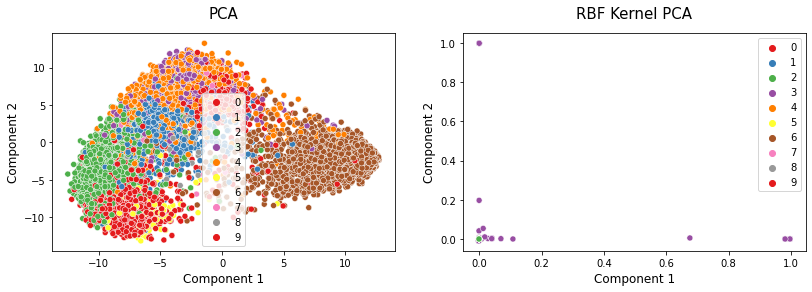

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13.5 ,4))
sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=y, palette='Set1', ax=ax[0])
sns.scatterplot(X_kpca[:, 0], X_kpca[:, 1], hue=y, palette='Set1', ax=ax[1])
ax[0].set_title("PCA", fontsize=15, pad=15)
ax[1].set_title("RBF Kernel PCA", fontsize=15, pad=15)
ax[0].set_xlabel("Component 1", fontsize=12)
ax[0].set_ylabel("Component 2", fontsize=12)
ax[1].set_xlabel("Component 1", fontsize=12)
ax[1].set_ylabel("Component 2", fontsize=12)
plt.savefig('PCA vs Kernel PCA.png', dpi=100)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


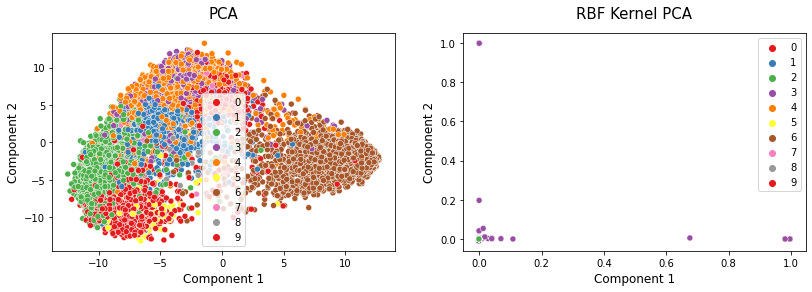

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13.5 ,4))
sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=y, palette='Set1', ax=ax[0])
sns.scatterplot(X_kpca[:, 0], X_kpca[:, 1], hue=y, palette='Set1', ax=ax[1])
ax[0].set_title("PCA", fontsize=15, pad=15)
ax[1].set_title("RBF Kernel PCA", fontsize=15, pad=15)
ax[0].set_xlabel("Component 1", fontsize=12)
ax[0].set_ylabel("Component 2", fontsize=12)
ax[1].set_xlabel("Component 1", fontsize=12)
ax[1].set_ylabel("Component 2", fontsize=12)
plt.savefig('PCA vs Kernel PCA.png', dpi=100)

In [ ]:
import tensorflow as tf
print(tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers

2.5.0


#creating the input for the transformer

In [ ]:
#creating the input for the transformer
x_train=[]
y_train=[]
for i in range(df_train.shape[0]):
  x_train.append(df_train["mean_emb"][i])
  y_train.append(df_train["label"][i])

In [ ]:
x_tr = np.array(x_train)
y_tr=np.array(y_train)

In [ ]:
x_tr.shape, y_tr.shape

((13552, 768), (13552,))

In [ ]:
#creating the validation input 
x_val=[]
y_val=[]
for i in range(df_val.shape[0]):
  x_val.append(df_val["mean_emb"][i])
  y_val.append(df_val["label"][i])

x_va = np.array(x_val)
y_va=np.array(y_val)

x_va.shape, y_va.shape

((3388, 768), (3388,))

In [ ]:
#creating the test input 
x_test=[]
y_test=[]
for i in range(df_test.shape[0]):
  x_test.append(df_test["mean_emb"][i])
  y_test.append(df_test["label"][i])

x_te = np.array(x_test)
y_te=np.array(y_test)

x_te.shape, y_te.shape

((202, 768), (202,))

In [ ]:
#creating the validation input 
x_e_tr=[]
y_e_tr=[]
for i in range(df_train.shape[0]):
  x_e_tr.append(df_train["emb"][i])
  y_e_tr.append(df_train["label"][i])

x_emb_tr = np.array(x_e_tr)
y_emb_tr=np.array(y_e_tr)

x_emb_tr.shape, y_emb_tr.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


((13552,), (13552,))

In [ ]:
df_train["emb"][0]

array([[-0.0211  , -0.288349,  0.72197 ,  0.324376, ...,  0.802411,  0.902796, -0.522767, -0.101945],
       [-0.613593, -0.196634,  0.545469,  0.765092, ...,  0.781981,  0.731322, -0.640408,  0.276129]], dtype=float32)

In [ ]:
type(x_emb_tr[0])

numpy.ndarray

In [ ]:
#creating the validation input 
x_e_val=[]
y_e_val=[]
for i in range(df_val.shape[0]):
  x_e_val.append(df_val["emb"][i])
  y_e_val.append(df_val["label"][i])

x_emb_val = np.array(x_e_val)
y_emb_val=np.array(y_e_val)

x_emb_val.shape, y_emb_val.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


((3388,), (3388,))

In [ ]:
#creating the validation input 
x_e_test=[]
y_e_test=[]
for i in range(df_test.shape[0]):
  x_e_test.append(df_test["emb"][i])
  y_e_test.append(df_test["label"][i])

x_emb_test = np.array(x_e_test)
y_emb_test=np.array(y_e_test)

x_emb_test.shape, y_emb_test.shape

((202, 5, 768), (202,))

In [ ]:
x_emb_test[0]

array([[ 0.905484, -0.439665,  0.487833, -0.930498, ...,  0.112375,  0.137263, -0.564621, -0.94157 ],
       [ 0.888559, -0.55981 ,  0.310729, -0.926052, ...,  0.522132, -0.091857, -0.516601, -0.920653],
       [ 0.817395, -0.587691,  0.022902, -0.899876, ...,  0.502195, -0.195852, -0.613516, -0.917648],
       [ 0.830759, -0.514598, -0.549505, -0.924031, ...,  0.668297, -0.828999, -0.413538, -0.658639],
       [ 0.903599, -0.489176,  0.847997, -0.956377, ...,  0.537001,  0.373665, -0.429996, -0.934402]], dtype=float32)

In [ ]:
#Masking the input for same length 
num_features=150
def input_generator(df):
    x_list= df['emb'].to_list()
    y_list= df.label.to_list()
    timesteps = len(max(df['emb'].to_list(), key=len))
    x_train= np.full((df['emb'].shape[0], timesteps, num_features), -99.)
    y_train = np.zeros((df['emb'].shape[0],  1))
    for b in range(len(x_list)):
        x_train[b, 0:len(x_list[b]), :] = x_list[b]
        y_train[b]=y_list[b]
    return x_train, y_train


In [ ]:
x_train_new,y_train_new=input_generator(df_train)
x_train_new.shape, y_train_new.shape

((13552, 4, 768), (13552, 1))

In [ ]:
x_val_new,y_val_new=input_generator(df_val)
x_val_new.shape, y_val_new.shape

((3388, 4, 768), (3388, 1))

# Transformer Model Creation

In [ ]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

In [ ]:

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [ ]:

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        #self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        print(positions)
        #x = self.token_emb(x)
        print(x)
        return x + positions


In [ ]:
df_train['emb'].shape

In [ ]:
vocab_size = 30  # Only consider the top 20k words
maxlen = 4  # Only consider the first 200 words of each movie review

In [ ]:

embed_dim = 768  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(None,768,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = inputs
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x,True)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


Tensor("token_and_position_embedding_2/embedding_2/embedding_lookup/Identity_1:0", shape=(?, 768), dtype=float32)
Tensor("input_3:0", shape=(?, ?, 768), dtype=float32)


In [ ]:
x_emb_tr[0].shape

(2, 768)

In [ ]:
print(tf.__version__)

2.5.0


In [ ]:
x_train_new.shape

(13552, 4, 768)

In [ ]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(x_train_new, y_train_new, batch_size=32, epochs=40, validation_data=(x_val_new, y_val_new))

Train on 13552 samples, validate on 3388 samples
Epoch 1/40
13312/13552 [============================>.] - ETA: 0s - loss: 0.6208 - acc: 0.8098

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


13552/13552 [==============================] - 3s 239us/sample - loss: 0.6209 - acc: 0.8097 - val_loss: 0.6674 - val_acc: 0.7999
Epoch 2/40
13552/13552 [==============================] - 3s 206us/sample - loss: 0.6647 - acc: 0.8000 - val_loss: 0.6780 - val_acc: 0.7931
Epoch 3/40
13552/13552 [==============================] - 3s 206us/sample - loss: 0.6643 - acc: 0.7981 - val_loss: 0.6574 - val_acc: 0.8037
Epoch 4/40
13552/13552 [==============================] - 3s 204us/sample - loss: 0.7473 - acc: 0.7830 - val_loss: 0.6877 - val_acc: 0.7946
Epoch 5/40
13552/13552 [==============================] - 3s 203us/sample - loss: 0.6128 - acc: 0.8212 - val_loss: 0.4582 - val_acc: 0.8843
Epoch 6/40
13552/13552 [==============================] - 3s 204us/sample - loss: 0.4712 - acc: 0.8675 - val_loss: 0.4866 - val_acc: 0.8439
Epoch 7/40
13552/13552 [==============================] - 3s 204us/sample - loss: 0.4870 - acc: 0.8393 - val_loss: 0.4805 - val_acc: 0.8430
Epoch 8/40
13552/13552 [=======

In [ ]:
x_test_new,y_test_new=input_generator(df_test)
x_test_new.shape, y_test_new.shape

((202, 5, 768), (202, 1))

In [ ]:
y_proba=model.predict(x_test_new)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
y_proba

array([[9.027434e-08, 3.889851e-05, 3.657653e-12, 2.174903e-05, ..., 2.652809e-03, 2.144997e-04, 9.700734e-05,
        9.890404e-01],
       [2.792854e-07, 9.998766e-01, 7.441630e-08, 9.730267e-06, ..., 1.914151e-10, 1.179892e-06, 2.513387e-06,
        3.028690e-07],
       [3.537511e-04, 3.276363e-05, 1.382831e-05, 1.975912e-07, ..., 9.977552e-01, 1.103436e-04, 3.281945e-07,
        1.504454e-10],
       [1.415591e-03, 3.978645e-04, 3.642303e-05, 2.909844e-05, ..., 9.548303e-01, 1.811554e-03, 7.091745e-05,
        4.616264e-08],
       ...,
       [2.234897e-05, 5.011218e-05, 1.428910e-06, 2.057262e-04, ..., 9.927182e-01, 4.368439e-06, 4.762219e-07,
        3.297347e-10],
       [2.654622e-03, 4.861393e-04, 8.883431e-05, 2.187428e-06, ..., 9.863436e-01, 8.217194e-04, 2.560095e-05,
        1.009410e-08],
       [2.371457e-03, 4.260127e-04, 7.784545e-01, 9.026015e-03, ..., 4.324513e-08, 3.308851e-05, 5.799739e-06,
        1.303655e-07],
       [3.832221e-03, 8.989450e-07, 7.370576e-05, 

In [ ]:
y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)

In [ ]:
#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test['label']))
print('Classification Report')
print(classification_report(y_pred, df_test['label']))

Confusion Matrix
[[23  0  2  0 ...  1  0  0  0]
 [ 0 15  2  0 ...  0  0  2  0]
 [ 2  0 23  0 ...  0  0  0  0]
 [ 0  0  0  9 ...  0  0  0  0]
 ...
 [ 0  0  0  0 ...  1  0  0  0]
 [ 1  2  0  0 ...  0 83  0  0]
 [ 0  0  0  0 ...  0  0  0  0]
 [ 0  0  0  0 ...  0  0  0  6]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        27
           1       0.88      0.75      0.81        20
           2       0.77      0.92      0.84        25
           3       0.90      0.90      0.90        10
           4       0.88      0.78      0.82        27
           5       0.50      1.00      0.67         1
           6       1.00      0.97      0.98        86
           8       0.00      0.00      0.00         0
           9       0.86      1.00      0.92         6

    accuracy                           0.90       202
   macro avg       0.74      0.80      0.76       202
weighted avg       0.92      0.90      0.90       202



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat = confusion_matrix(y_pred, df_test['label'])

diag = np.diagonal(mat)
print('No of correctly identified labels :',sum(diag))
print('No of misclassified samples : ',sum(sum(mat))-sum(diag))

No of correctly identified labels : 181
No of misclassified samples :  21


In [ ]:
y_proba=model.predict(x_te)

In [ ]:
y_proba

array([[0.111036, 0.060999, 0.134507, 0.118398, ..., 0.330741, 0.002619, 0.005043, 0.037773],
       [0.111038, 0.06101 , 0.134523, 0.118377, ..., 0.330754, 0.00262 , 0.005043, 0.037784],
       [0.111036, 0.060999, 0.134507, 0.118398, ..., 0.330741, 0.002619, 0.005043, 0.037773],
       [0.111036, 0.060999, 0.134507, 0.118398, ..., 0.330741, 0.002619, 0.005043, 0.037773],
       ...,
       [0.111036, 0.060999, 0.134507, 0.118398, ..., 0.330741, 0.002619, 0.005043, 0.037773],
       [0.111036, 0.060999, 0.134507, 0.118398, ..., 0.330741, 0.002619, 0.005043, 0.037773],
       [0.111036, 0.060999, 0.134507, 0.118398, ..., 0.330741, 0.002619, 0.005043, 0.037773],
       [0.111036, 0.060999, 0.134507, 0.118398, ..., 0.330741, 0.002619, 0.005043, 0.037773]], dtype=float32)

In [ ]:
#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test['label']))
print('Classification Report')
print(classification_report(y_pred, df_test['label']))

Confusion Matrix
[[ 0  0  0  0 ...  0  0  0  0]
 [ 0  0  0  0 ...  0  0  0  0]
 [ 0  0  0  0 ...  0  0  0  0]
 [ 0  0  0  0 ...  0  0  0  0]
 ...
 [ 0  0  0  0 ...  0  0  0  0]
 [26 17 30 10 ...  2 83  3  7]
 [ 0  0  0  0 ...  0  0  0  0]
 [ 0  0  0  0 ...  0  0  0  0]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.41      0.58       202
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.41       202
   macro avg       0.11      0.05      0.06       202
weighted avg       1.00      0.41      0.58       202



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat = confusion_matrix(y_pred, df_test['label'])

diag = np.diagonal(mat)
print('No of correctly identified labels :',sum(diag))
print('No of misclassified samples : ',sum(sum(mat))-sum(diag))

No of correctly identified labels : 83
No of misclassified samples :  119


In [ ]:
tr_emb.shape[0]

30891

In [ ]:
tr_emb.shape[1]

768

In [ ]:
from keras.layers import Layer
import keras.backend as K

In [ ]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

# LSTM Model creation

In [ ]:
X_pca.shape , y.shape , X_val_pca.shape , y_val.shape , X_test_pca.shape, y_test.shape

((13552, 768), (13552,), (3388, 768), (3388,), (202, 202), (202,))

In [ ]:
X_kpca.shape , y.shape , X_val_kpca.shape , y_val.shape , X_test_kpca.shape, y_test.shape

((13552, 768), (13552,), (3388, 768), (3388,), (202, 202), (202,))

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
tf.__version__

'2.5.0'

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from tensorflow.keras.models import Sequential, Model
text_input = Input(shape=(None,500,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,return_sequences=True)(l_mask)
# att_out=attention()(encoded_text)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# # And we add a softmax classifier on top
# out = layers.Dense(len(label_list), activation='softmax')(out_dense)
out = layers.Dense(10, activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model500 = Model(text_input, out)
model500.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model500.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None, 500)]       0         
_________________________________________________________________
masking_3 (Masking)          (None, None, 500)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 100)         240400    
_________________________________________________________________
dense_6 (Dense)              (None, None, 30)          3030      
_________________________________________________________________
dense_7 (Dense)              (None, None, 10)          310       
Total params: 243,740
Trainable params: 243,740
Non-trainable params: 0
_________________________________________________________________


In [ ]:
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,return_sequences=True)(l_mask)
# att_out=attention()(encoded_text)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# # And we add a softmax classifier on top
# out = layers.Dense(len(label_list), activation='softmax')(out_dense)
out = layers.Dense(10, activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
modelnew = Model(text_input, out)
modelnew.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
modelnew.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None, 768)]       0         
_________________________________________________________________
masking_5 (Masking)          (None, None, 768)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 100)         347600    
_________________________________________________________________
dense_10 (Dense)             (None, None, 30)          3030      
_________________________________________________________________
dense_11 (Dense)             (None, None, 10)          310       
Total params: 350,940
Trainable params: 350,940
Non-trainable params: 0
_________________________________________________________________


In [ ]:
type(X_pca)

numpy.ndarray

In [ ]:
#creating the kpca dataframe for LSTM 
x_tr_kpca=[]
for i in range(df_train.shape[0]):
  x_tr_kpca.append(np.array(X_kpca[i],ndmin=2))
  # y_train.append(df_train["label"][i])
df_train_kpca = pd.DataFrame({'emb': x_tr_kpca, 'label': y, })
df_train_kpca.head()

x_va_kpca=[]
for i in range(df_val.shape[0]):
  x_va_kpca.append(np.array(X_val_kpca[i],ndmin=2))
df_val_kpca = pd.DataFrame({'emb': x_va_kpca, 'label': y_val, })
df_val_kpca.head()

x_te_kpca=[]
for i in range(df_test.shape[0]):
  x_te_kpca.append(np.array(X_test_kpca[i],ndmin=2))
df_test_kpca = pd.DataFrame({'emb': x_te_kpca, 'label': y_test, })
df_test_kpca.head()

,emb,label
0,"[[-0.0, -0.0, -0.0, 0.0, 0.0, -0.0, 0.0, 0.0, ...",6
1,"[[-0.029514829, 0.040868476, -0.020064287, -0....",6
2,"[[0.0015742587, 0.0013612601, -0.005949099, -0...",6
3,"[[0.00078321464, 0.011071527, 0.0071595632, 0....",6
4,"[[-0.09018516, -0.086427465, 0.020753216, 0.01...",2


In [ ]:
df_train_kpca.shape , df_val_kpca.shape , df_test_kpca.shape

((13552, 2), (3388, 2), (202, 2))

In [ ]:
#creating the pca dataframe for LSTM 

x_tr_pca=[]
for i in range(df_train.shape[0]):
  x_tr_pca.append(np.array(X_pca[i],ndmin=2))
  # y_train.append(df_train["label"][i])
df_train_pca = pd.DataFrame({'emb': x_tr_pca, 'label': y, })
df_train_pca.head()

x_va_pca=[]
for i in range(df_val.shape[0]):
  x_va_pca.append(np.array(X_val_pca[i],ndmin=2))
df_val_pca = pd.DataFrame({'emb': x_va_pca, 'label': y_val, })
df_val_pca.head()

x_te_pca=[]
for i in range(df_test.shape[0]):
  x_te_pca.append(np.array(X_test_pca[i],ndmin=2))
df_test_pca = pd.DataFrame({'emb': x_te_pca, 'label': y_test, })
df_test_pca.head()

,emb,label
0,"[[7.8898387, 0.35465854, -0.74946994, -0.73733...",6
1,"[[3.8773124, 3.187268, 2.2361355, -2.5461347, ...",6
2,"[[9.676129, 0.47385344, -1.3912141, -1.1072408...",6
3,"[[10.855628, 1.7838126, -1.575305, 1.146587, -...",6
4,"[[-9.327382, 1.726364, -5.5898414, -4.124965, ...",2


In [ ]:
df_train_pca.shape , df_val_pca.shape , df_test_pca.shape

((13552, 2), (3388, 2), (202, 2))

In [ ]:
num_sequences = len(df_train_pca['emb'].to_list())
batch_size = 4
batches_per_epoch =  3388
assert batch_size * batches_per_epoch == num_sequences
num_features= 768
def train_generator_new(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            #print(x_train.shape , y_train.shape)
            yield x_train, y_train


In [ ]:
df_train['emb'][0]

array([[-0.4676593 ,  0.14724328, -0.8827459 , ..., -0.82500774,
         0.4735413 ,  0.95219964],
       [-0.22119352,  0.41026565, -0.96930635, ..., -0.8069091 ,
         0.0626434 ,  0.93483937]], dtype=float32)

In [ ]:
def train_generator(df):
    x_list= df['emb'].to_list()
    print('x_list :',len(x_list) )
    y_list =  df.label.to_list()
    # Generate batches
    for b in range(batches_per_epoch):
        print('b: ',b)
        longest_index = (b + 1) * batch_size - 1
        print('longest_index :',longest_index)
        print(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
        timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
        print('timesteps :',timesteps)
        x_train = np.full((batch_size, timesteps, num_features), -99.)
        y_train = np.zeros((batch_size,  1))
        for i in range(batch_size):
            li = b * batch_size + i
            x_train[i, 0:len(x_list[li]), :] = x_list[li]
            y_train[i] = y_list[li]
        print(x_train.shape , y_train.shape)
        print('---------')
        return x_train, y_train

In [ ]:
num_features= 768
x_p, y_p= train_generator(df_train)

x_list : 13552
b:  0
longest_index : 3
[[-0.4676593   0.14724328 -0.8827459  ... -0.82500774  0.4735413
   0.95219964]
 [-0.22119352  0.41026565 -0.96930635 ... -0.8069091   0.0626434
   0.93483937]]
timesteps : 2
(4, 2, 768) (4, 1)
---------


In [ ]:
num_features= 150
x_p, y_p= train_generator(df_train_pca_new)

x_list : 13552
b:  0
longest_index : 3
[[-5.11111641e+00  5.02894688e+00 -6.01223469e+00  1.22594910e+01
   4.44989014e+00 -3.32102990e+00 -1.25423038e+00 -2.90294027e+00
  -2.95091391e-01 -1.18472862e+00 -1.85002625e+00 -7.43027866e-01
   3.69427592e-01 -6.52508736e-01 -1.61397979e-01  2.75647268e-02
   2.46263206e-01  2.33053088e-01  5.71861342e-02 -2.81025797e-01
   9.86435264e-02  7.85834417e-02 -1.45908043e-01  1.12041764e-01
   3.46478879e-01 -2.03056321e-01  1.28206536e-01 -5.52704632e-01
  -7.66409114e-02  2.19931856e-01  1.23768330e-01 -2.27163672e-01
   2.14045253e-02 -2.05890253e-01 -1.72378257e-01 -3.70048173e-02
  -1.55515403e-01  8.10440108e-02 -3.43725741e-01  4.19440009e-02
   2.09611624e-01  3.06654006e-01 -2.08872631e-02 -1.88662335e-02
  -1.88585483e-02  5.39682843e-02  1.00099839e-01  9.24598426e-02
   1.21653993e-02 -2.93989867e-01  1.05934283e-02 -5.37375472e-02
  -1.30467042e-01 -8.94064233e-02  4.19555716e-02  3.53831261e-01
  -3.18221338e-02 -1.59525089e-02 -6.

In [ ]:
num_sequences_val = len(df_val_pca['emb'].to_list())
batch_size_val = 4
batches_per_epoch_val = 847
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
def val_generator_new(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((13552, 3), (3388, 3), (202, 3))

In [ ]:
13552, 3, 768 ==>13552,1,150

,emb,label,mean_emb
0,"[[-0.4676593, 0.14724328, -0.8827459, 0.856973...",1,"[-0.3444264, 0.27875447, -0.9260261, 0.8091671..."
1,"[[0.7654536, -0.3047139, -0.954275, -0.4499121...",3,"[0.7654536, -0.3047139, -0.954275, -0.4499121,..."
2,"[[0.7149185, 0.8784548, -0.0600981, -0.7525436...",3,"[0.7149185, 0.8784548, -0.0600981, -0.7525436,..."
3,"[[0.69485337, -0.742411, -0.73213583, -0.35592...",4,"[0.68209875, -0.7316514, -0.74696326, -0.33999..."
4,"[[0.7575402, -0.32592666, -0.14666598, -0.5177...",4,"[0.7002898, -0.29207325, -0.1383036, -0.317435..."
...,...,...,...
13547,"[[-0.60229355, -0.659548, -0.92286974, 0.90314...",2,"[0.106040604, -0.33704576, -0.9644529, 0.52130..."
13548,"[[0.8312326, -0.72575754, -0.7635738, -0.42647...",6,"[0.8312326, -0.72575754, -0.7635738, -0.426476..."
13549,"[[0.6254029, 0.81965697, -0.40367526, -0.74304...",3,"[0.63485307, 0.7946311, -0.51452553, -0.711726..."
13550,"[[-0.5137969, -0.31365255, -0.9789185, 0.90656...",2,"[-0.28326535, -0.54598224, -0.9894284, 0.91639..."


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [ ]:
model1.fit_generator(train_generator(df_train_pca_new), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val_pca_new), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1246: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/10
3383/3388 [============================>.] - ETA: 0s - batch: 1691.0000 - size: 4.0000 - loss: 0.3237 - acc: 0.3819

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3388/3388 [==============================] - 24s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 0.3241 - acc: 0.3820 - val_loss: 1.7435 - val_acc: 0.2907 - lr: 0.0010
Epoch 2/10
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 0.2489 - acc: 0.3847 - val_loss: 1.8265 - val_acc: 0.2903 - lr: 0.0010
Epoch 3/10
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 0.2267 - acc: 0.3858 - val_loss: 1.9654 - val_acc: 0.2920 - lr: 0.0010
Epoch 4/10
3386/3388 [============================>.] - ETA: 0s - batch: 1692.5000 - size: 4.0000 - loss: 0.2078 - acc: 0.3870
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 0.2077 - acc: 0.3870 - val_loss: 2.1341 - val_acc: 0.2941 - lr: 0.0010
Epoch 5/10
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000

In [ ]:
model1.fit_generator(train_generator(df_train_kpca), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val_kpca), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

Epoch 1/10
  29/3388 [..............................] - ETA: 19s - batch: 14.0000 - size: 4.0000 - loss: 1.9194 - acc: 0.3621

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1246: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 1.8329 - acc: 0.3477 - val_loss: 1.8098 - val_acc: 0.3580 - lr: 8.5737e-04
Epoch 2/10
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 1.7934 - acc: 0.3497 - val_loss: 1.8309 - val_acc: 0.3532 - lr: 8.5737e-04
Epoch 3/10
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 1.7721 - acc: 0.3508 - val_loss: 1.8983 - val_acc: 0.3427 - lr: 8.5737e-04
Epoch 4/10
3384/3388 [============================>.] - ETA: 0s - batch: 1691.5000 - size: 4.0000 - loss: 1.7642 - acc: 0.3512
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0008145062311086804.
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 1.7644 - acc: 0.3512 - val_loss: 1.9920 - val_acc: 0.3351 - lr: 8.5737e-04
Epoch 5/10
3388/3388 [==============================] - 23s 7ms/step - 

In [ ]:
model500.fit_generator(train_generator(df_train_pca), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val_pca), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1246: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/10
3380/3388 [============================>.] - ETA: 0s - batch: 1689.5000 - size: 4.0000 - loss: 0.3193 - acc: 0.3820

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3388/3388 [==============================] - 24s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 0.3198 - acc: 0.3821 - val_loss: 1.8219 - val_acc: 0.2916 - lr: 0.0010
Epoch 2/10
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 0.2354 - acc: 0.3852 - val_loss: 1.9051 - val_acc: 0.2952 - lr: 0.0010
Epoch 3/10
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 0.2021 - acc: 0.3876 - val_loss: 2.1012 - val_acc: 0.2958 - lr: 0.0010
Epoch 4/10
3384/3388 [============================>.] - ETA: 0s - batch: 1691.5000 - size: 4.0000 - loss: 0.1714 - acc: 0.3897
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 0.1718 - acc: 0.3898 - val_loss: 2.3125 - val_acc: 0.2978 - lr: 0.0010
Epoch 5/10
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000

In [ ]:
df_train_pca['emb'][0].shape

(1, 768)

In [ ]:
model768.fit_generator(train_generator(df_train_pca), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val_pca), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1246: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/10
3387/3388 [============================>.] - ETA: 0s - batch: 1693.0000 - size: 4.0000 - loss: 0.3208 - acc: 0.3817

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3388/3388 [==============================] - 25s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 0.3207 - acc: 0.3817 - val_loss: 1.8982 - val_acc: 0.2937 - lr: 0.0010
Epoch 2/10
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 0.2310 - acc: 0.3858 - val_loss: 2.0043 - val_acc: 0.2972 - lr: 0.0010
Epoch 3/10
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 0.1934 - acc: 0.3886 - val_loss: 2.1292 - val_acc: 0.2983 - lr: 0.0010
Epoch 4/10
3387/3388 [============================>.] - ETA: 0s - batch: 1693.0000 - size: 4.0000 - loss: 0.1598 - acc: 0.3911
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 0.1597 - acc: 0.3911 - val_loss: 2.3177 - val_acc: 0.3015 - lr: 0.0010
Epoch 5/10
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000

In [ ]:
df_train_kpca['emb'][0].shape

(1, 768)

In [ ]:
model768.fit_generator(train_generator(df_train_kpca), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val_kpca), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

Epoch 1/10
  27/3388 [..............................] - ETA: 20s - batch: 13.0000 - size: 4.0000 - loss: 2.2543 - acc: 0.3102

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1246: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


3388/3388 [==============================] - 24s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 1.8624 - acc: 0.3410 - val_loss: 1.8572 - val_acc: 0.3538 - lr: 8.5737e-04
Epoch 2/10
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 1.7779 - acc: 0.3483 - val_loss: 1.8970 - val_acc: 0.3405 - lr: 8.5737e-04
Epoch 3/10
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 1.7116 - acc: 0.3501 - val_loss: 2.0119 - val_acc: 0.3196 - lr: 8.5737e-04
Epoch 4/10
3386/3388 [============================>.] - ETA: 0s - batch: 1692.5000 - size: 4.0000 - loss: 1.6758 - acc: 0.3485
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0008145062311086804.
3388/3388 [==============================] - 23s 7ms/step - batch: 1693.5000 - size: 4.0000 - loss: 1.6757 - acc: 0.3485 - val_loss: 2.1632 - val_acc: 0.2969 - lr: 8.5737e-04
Epoch 5/10
3388/3388 [==============================] - 24s 7ms/step - 

In [ ]:
df_train['emb'][0].shape

(2, 768)

In [ ]:
batches_per_epoch_val

847

In [ ]:
modelnew.fit_generator(train_generator_new(df_train), steps_per_epoch=batches_per_epoch, epochs=10,validation_data=val_generator_new(df_val), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1246: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
num_sequences_val = len(df_test['mean_emb'].to_list())
batch_size_val = 2
batches_per_epoch_val = 101
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
model.evaluate_generator(val_generator(df_test), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1261: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.2631700588482441, 0.9059406]

In [ ]:
num_sequences_val = len(df_test['mean_emb'].to_list())
batch_size_val = 2
batches_per_epoch_val = 101
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
y_proba=model.predict(val_generator(df_test), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)

In [ ]:
#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test['label']))
print('Classification Report')
print(classification_report(y_pred, df_test['label']))

Confusion Matrix
[[23  1  4  0 ...  1  1  1  0]
 [ 0 14  0  0 ...  0  0  1  0]
 [ 2  1 24  0 ...  0  0  0  0]
 [ 0  0  0  9 ...  0  0  0  0]
 ...
 [ 1  0  0  0 ...  1  0  0  0]
 [ 0  1  0  0 ...  0 82  0  0]
 [ 0  0  0  0 ...  0  0  1  0]
 [ 0  0  0  0 ...  0  0  0  7]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.72      0.79        32
           1       0.82      0.88      0.85        16
           2       0.80      0.89      0.84        27
           3       0.90      1.00      0.95         9
           4       0.92      0.88      0.90        25
           5       0.50      0.50      0.50         2
           6       0.99      0.99      0.99        83
           8       0.33      1.00      0.50         1
           9       1.00      1.00      1.00         7

    accuracy                           0.91       202
   macro avg       0.79      0.87      0.81       202
weighted avg       0.91      0.91      0.91       202



In [ ]:
mat = confusion_matrix(y_pred, df_test['label'])

In [ ]:
print(mat)

[[23  1  4  0 ...  1  1  1  0]
 [ 0 14  0  0 ...  0  0  1  0]
 [ 2  1 24  0 ...  0  0  0  0]
 [ 0  0  0  9 ...  0  0  0  0]
 ...
 [ 1  0  0  0 ...  1  0  0  0]
 [ 0  1  0  0 ...  0 82  0  0]
 [ 0  0  0  0 ...  0  0  1  0]
 [ 0  0  0  0 ...  0  0  0  7]]


In [ ]:
diag = np.diagonal(mat)
sum(diag)

183

In [ ]:
sum(sum(mat))-sum(diag)

19

In [ ]:
#Just for reference -->DO NOT RUN IT
# #BERT: Fine Tuning Training & Evaluating
# print(f'Beginning Training!')
# #current_time = datetime.time()
# estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
# #print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 2.269146, step = 0


INFO:tensorflow:loss = 2.269146, step = 0


INFO:tensorflow:global_step/sec: 2.03454


INFO:tensorflow:global_step/sec: 2.03454


INFO:tensorflow:loss = 1.0293264, step = 100 (49.153 sec)


INFO:tensorflow:loss = 1.0293264, step = 100 (49.153 sec)


INFO:tensorflow:global_step/sec: 2.47521


INFO:tensorflow:global_step/sec: 2.47521


INFO:tensorflow:loss = 1.0047464, step = 200 (40.401 sec)


INFO:tensorflow:loss = 1.0047464, step = 200 (40.401 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:global_step/sec: 2.14739


INFO:tensorflow:global_step/sec: 2.14739


INFO:tensorflow:loss = 0.8332013, step = 300 (46.568 sec)


INFO:tensorflow:loss = 0.8332013, step = 300 (46.568 sec)


INFO:tensorflow:global_step/sec: 2.47347


INFO:tensorflow:global_step/sec: 2.47347


INFO:tensorflow:loss = 1.0196545, step = 400 (40.429 sec)


INFO:tensorflow:loss = 1.0196545, step = 400 (40.429 sec)


INFO:tensorflow:global_step/sec: 2.47606


INFO:tensorflow:global_step/sec: 2.47606


INFO:tensorflow:loss = 0.5582099, step = 500 (40.387 sec)


INFO:tensorflow:loss = 0.5582099, step = 500 (40.387 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:global_step/sec: 2.16216


INFO:tensorflow:global_step/sec: 2.16216


INFO:tensorflow:loss = 0.70514524, step = 600 (46.250 sec)


INFO:tensorflow:loss = 0.70514524, step = 600 (46.250 sec)


INFO:tensorflow:global_step/sec: 2.47374


INFO:tensorflow:global_step/sec: 2.47374


INFO:tensorflow:loss = 1.2256243, step = 700 (40.425 sec)


INFO:tensorflow:loss = 1.2256243, step = 700 (40.425 sec)


INFO:tensorflow:global_step/sec: 2.47581


INFO:tensorflow:global_step/sec: 2.47581


INFO:tensorflow:loss = 0.23693301, step = 800 (40.391 sec)


INFO:tensorflow:loss = 0.23693301, step = 800 (40.391 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...


INFO:tensorflow:Saving checkpoints for 900 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 900 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...


INFO:tensorflow:global_step/sec: 2.13953


INFO:tensorflow:global_step/sec: 2.13953


INFO:tensorflow:loss = 1.0314894, step = 900 (46.739 sec)


INFO:tensorflow:loss = 1.0314894, step = 900 (46.739 sec)


INFO:tensorflow:global_step/sec: 2.47311


INFO:tensorflow:global_step/sec: 2.47311


INFO:tensorflow:loss = 0.50885725, step = 1000 (40.436 sec)


INFO:tensorflow:loss = 0.50885725, step = 1000 (40.436 sec)


INFO:tensorflow:global_step/sec: 2.47567


INFO:tensorflow:global_step/sec: 2.47567


INFO:tensorflow:loss = 0.3976738, step = 1100 (40.393 sec)


INFO:tensorflow:loss = 0.3976738, step = 1100 (40.393 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1200...


INFO:tensorflow:Saving checkpoints for 1200 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1200 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1200...


INFO:tensorflow:global_step/sec: 2.14793


INFO:tensorflow:global_step/sec: 2.14793


INFO:tensorflow:loss = 0.48501277, step = 1200 (46.556 sec)


INFO:tensorflow:loss = 0.48501277, step = 1200 (46.556 sec)


INFO:tensorflow:global_step/sec: 2.47377


INFO:tensorflow:global_step/sec: 2.47377


INFO:tensorflow:loss = 0.2039797, step = 1300 (40.424 sec)


INFO:tensorflow:loss = 0.2039797, step = 1300 (40.424 sec)


INFO:tensorflow:global_step/sec: 2.47695


INFO:tensorflow:global_step/sec: 2.47695


INFO:tensorflow:loss = 0.35457504, step = 1400 (40.372 sec)


INFO:tensorflow:loss = 0.35457504, step = 1400 (40.372 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1500...


INFO:tensorflow:Saving checkpoints for 1500 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1500...


INFO:tensorflow:global_step/sec: 2.08047


INFO:tensorflow:global_step/sec: 2.08047


INFO:tensorflow:loss = 0.5878937, step = 1500 (48.067 sec)


INFO:tensorflow:loss = 0.5878937, step = 1500 (48.067 sec)


INFO:tensorflow:global_step/sec: 2.47501


INFO:tensorflow:global_step/sec: 2.47501


INFO:tensorflow:loss = 0.3608415, step = 1600 (40.403 sec)


INFO:tensorflow:loss = 0.3608415, step = 1600 (40.403 sec)


INFO:tensorflow:global_step/sec: 2.47714


INFO:tensorflow:global_step/sec: 2.47714


INFO:tensorflow:loss = 0.36334234, step = 1700 (40.369 sec)


INFO:tensorflow:loss = 0.36334234, step = 1700 (40.369 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1800...


INFO:tensorflow:Saving checkpoints for 1800 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1800 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1800...


INFO:tensorflow:global_step/sec: 2.15762


INFO:tensorflow:global_step/sec: 2.15762


INFO:tensorflow:loss = 0.2758512, step = 1800 (46.347 sec)


INFO:tensorflow:loss = 0.2758512, step = 1800 (46.347 sec)


INFO:tensorflow:global_step/sec: 2.47499


INFO:tensorflow:global_step/sec: 2.47499


INFO:tensorflow:loss = 0.64759105, step = 1900 (40.404 sec)


INFO:tensorflow:loss = 0.64759105, step = 1900 (40.404 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1982...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1982...


INFO:tensorflow:Saving checkpoints for 1982 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1982 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1982...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1982...


INFO:tensorflow:Loss for final step: 0.43535817.


INFO:tensorflow:Loss for final step: 0.43535817.
